In [1]:
!pip install --user -r requirements.txt > /tmp/pip.log 2>&1 || cat /tmp/pip.log

### Shutup Tensorflow

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

**Tell tensorflow to not preallocate memory for each session**

In [3]:
## FIX CUDA_ERROR_OUT_OF_MEMORY
import keras.backend as K

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
session = K.tf.Session(config=config)

Using TensorFlow backend.


### Imports

In [4]:
import re
import glob
import email
import time 
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import shuffle
from bs4 import BeautifulSoup
from flanker import mime
from zipfile import ZipFile

from geoip2 import database as geoip_database
from geoip2 import errors as geoip_errors

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ProgbarLogger

from tensorflow.python.saved_model import tag_constants, signature_constants
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def
from tensorflow.python.saved_model.signature_def_utils import is_valid_signature

**Not a fan of the wide margins in Jupyter Notebooks. This code snipit removes those margins.**

In [5]:
## FIX MARGINS
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Init GeoIP lookup

In [6]:
# Uncomment this section to download the geoip database
# curl https://geolite.maxmind.com/download/geoip/database/GeoLite2-City_20190326.tar.gz | tar -xzv

In [7]:
geoip = geoip_database.Reader('GeoLite2-City_20190326/GeoLite2-City.mmdb')

### Grok Patterns
https://github.com/elastic/logstash/blob/v1.4.2/patterns/grok-patterns

In [8]:
RE_IPV6 = r"((([0-9A-Fa-f]{1,4}:){7}([0-9A-Fa-f]{1,4}|:))|(([0-9A-Fa-f]{1,4}:){6}(:[0-9A-Fa-f]{1,4}|((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){5}(((:[0-9A-Fa-f]{1,4}){1,2})|:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3})|:))|(([0-9A-Fa-f]{1,4}:){4}(((:[0-9A-Fa-f]{1,4}){1,3})|((:[0-9A-Fa-f]{1,4})?:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){3}(((:[0-9A-Fa-f]{1,4}){1,4})|((:[0-9A-Fa-f]{1,4}){0,2}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){2}(((:[0-9A-Fa-f]{1,4}){1,5})|((:[0-9A-Fa-f]{1,4}){0,3}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(([0-9A-Fa-f]{1,4}:){1}(((:[0-9A-Fa-f]{1,4}){1,6})|((:[0-9A-Fa-f]{1,4}){0,4}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:))|(:(((:[0-9A-Fa-f]{1,4}){1,7})|((:[0-9A-Fa-f]{1,4}){0,5}:((25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)(\.(25[0-5]|2[0-4]\d|1\d\d|[1-9]?\d)){3}))|:)))(%.+)?"
RE_IPV4 = r"(?<![0-9])(?:(?:25[0-5]|2[0-4][0-9]|[0-1]?[0-9]{1,2})[.](?:25[0-5]|2[0-4][0-9]|[0-1]?[0-9]{1,2})[.](?:25[0-5]|2[0-4][0-9]|[0-1]?[0-9]{1,2})[.](?:25[0-5]|2[0-4][0-9]|[0-1]?[0-9]{1,2}))(?![0-9])"
RE_IP = r"(?:%s|%s)" % (RE_IPV6, RE_IPV4)
RE_HOSTNAME = r"\b(?:[0-9A-Za-z][0-9A-Za-z-]{0,62})(?:\.(?:[0-9A-Za-z][0-9A-Za-z-]{0,62}))*(\.?|\b)"
RE_IPORHOST = r"(?:%s|(?P<HOST>%s))" % (RE_IP, RE_HOSTNAME)
RE_POSINT = r"\b(?:[1-9][0-9]*)\b"
RE_USERNAME = r"[a-zA-Z0-9._-]+"
RE_URIPROTO = r"[A-Za-z]+(\+[A-Za-z+]+)?"
RE_URIHOST = r"%s(?::%s)?" % (RE_IPORHOST, RE_POSINT)
RE_URIPATH = r"(?:/[A-Za-z0-9$.+!*'(){},~:;=@#%_\-]*)+"
RE_URIPARAM = r"\?[A-Za-z0-9$.+!*'|(){},~@#%&/=:;_?\-\[\]]*"
RE_URIPATHPARAM = r"%s(?:%s)?" % (RE_URIPATH, RE_URIPARAM)
RE_URI = r"%s://(?:%s(?::[^@]*)?@)?(?:%s)?(?:%s)?" % (RE_URIPROTO, RE_USERNAME, RE_URIHOST, RE_URIPATHPARAM)

### Dataset Parsing

In [9]:
start_time = time.time()

data = pd.DataFrame(columns = ["class", "text"]) 

data_clean_files = list(glob.glob("data/clean/*.eml"))
print("Found %i clean emails" % len(data_clean_files))

data_spam_files = list(glob.glob("data/spam/*.eml"))
print("Found %i spam emails" % len(data_spam_files))

data_files = list(zip(data_clean_files, [0] * len(data_clean_files)))
data_files = data_files + list(zip(data_spam_files, [1] * len(data_spam_files)))
shuffle(data_files)

re_non_word = re.compile('[^\w,\.]+')
re_numbers = re.compile('(?<=[\s_\.,-])\d+(?=[\s_\.,-])')
re_uri = re.compile(RE_URI)

for email_file, data_class in data_files:

    with open(email_file, "rb") as f:
        rfc822_message = f.read()

    # parse the message 
    email_message = email.message_from_bytes(rfc822_message)

    # detect country from ip
    country = ""
    if email_message.get('X-Originating-Ip'):
        ip = re.sub(r'\[|\]', '', email_message.get('X-Originating-Ip'))
        try:
            country = str(geoip.city(ip).country.iso_code)
        except geoip_errors.AddressNotFoundError:
            pass
    
    # extract the message body
    message_text = b""
    message_html = b""
    for part in email_message.walk():
        if part.get_content_type() == "text/html":
            message_html += part.get_payload(decode=True)
        if part.get_content_type() == "text/plain":
            message_text += part.get_payload(decode=True)
    
    # convert byte strings to ascii
    message_text = message_text.decode("utf-8", errors="ignore")
    message_html = message_html.decode("utf-8", errors="ignore")
    
    # convert html to text if no plain text body
    if message_html != "" and message_text == "":
        soup = BeautifulSoup(message_html, 'html.parser')
        message_text = soup.get_text()

    # drop emails that cannot be decoded to text
    if message_text == "":
        continue

    text = "%s %s" % (email_message.get('Subject'), message_text)
        
    # remove line breaks
    text = text.replace('\n', ' ')
    text = text.replace('\r', '')
    
    # replace links with just the domain
    text =  re_uri.sub(r"\g<HOST>", text)
    
    text = re_non_word.sub(' ', text)
    
    # shrink whitespace 
    text = re.sub(r"\s+", " ", text)
    
    # replace numbers with 0000
    text =  re_numbers.sub('0000', text)

    # covert all text to lower case
    text =  text.lower()

    eml = {
        "class": data_class,
        "text": text, 
    }
    data = data.append(eml, ignore_index=True)

print("Loaded %i emails" % len(data))
print("Elapsed time", time.time() - start_time)

Found 9063 clean emails
Found 2967 spam emails
Loaded 12028 emails
Elapsed time 93.88229274749756


### Text to sequence vectors

Keras text processing utility to convert text to sequences http://faroit.com/keras-docs/1.2.2/preprocessing/text/#tokenizer

In [10]:
start_time = time.time()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(data["text"]))
data["text_sequence"] = list(tokenizer.texts_to_sequences(list(data["text"])))
print("Elapsed time", time.time() - start_time)

print("%i tokens in corpus" % (len(tokenizer.index_word)))

Elapsed time 3.48954176902771
44792 tokens in corpus


In [11]:
data.head()

,class,text,text_sequence
0,1,keto control...burn fat with zero exercise ket...,"[1812, 1115, 2458, 1640, 28, 2821, 1821, 1812,..."
1,0,christian brown s invitation is waiting for yo...,"[6237, 2477, 24, 2796, 19, 2231, 12, 13, 822, ..."
2,0,utf 0000 q weekly_coding_challenges _template...,"[374, 1, 434, 235, 3180, 2008, 1290, 3181, 455..."
3,0,re wp co reminder conference call tonight 8pm ...,"[84, 527, 160, 1065, 275, 114, 613, 1061, 616,..."
4,1,big pharma doesn t wan t you read this big pha...,"[326, 4843, 889, 74, 7927, 74, 7, 400, 9, 326,..."


### Trim and pad sequences

Standardize the length of each vector.

In [12]:
print("Longest text sequence is %i" % data["text_sequence"].apply(lambda x: len(x)).max())
print("Shortest text sequence is %i" % data["text_sequence"].apply(lambda x: len(x)).min())

Longest text sequence is 19860
Shortest text sequence is 0


In [13]:
max_sequence_length = 300
data["text_sequence"] = data["text_sequence"].apply(lambda x: x[0:max_sequence_length] if len(x) >= max_sequence_length else x + [0] * (max_sequence_length - len(x)))

In [14]:
print("Longest text sequence is %i" % data["text_sequence"].apply(lambda x: len(x)).max())
print("Shortest text sequence is %i" % data["text_sequence"].apply(lambda x: len(x)).min())

Longest text sequence is 300
Shortest text sequence is 300


### Split Test and Train 

In [15]:
# Split data into examples, and labels
X = np.array(list(data["text_sequence"]))
y = np.array(list(data["class"]))

# reshape the example data
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# split into test, train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

print("X_train", len(X_train), X_train.shape)
print("y_train", len(y_train), y_train.shape)
print("X_test", len(X_test), X_test.shape)
print("y_test", len(y_test), y_test.shape)

X_train 8058 (8058, 300, 1)
y_train 8058 (8058,)
X_test 3970 (3970, 300, 1)
y_test 3970 (3970,)


### Compute class weights

In [16]:
classes = np.unique(y)
class_weights = {}
for i, w in enumerate(compute_class_weight(class_weight='balanced', classes=classes, y=y)):
    class_weights[int(classes[i])] = float(w)
    
class_weights

{0: 0.6637236508111688, 1: 2.0269632625547693}

### Define the LSTM model

In [17]:
model = Sequential()
model.add(LSTM(units=300, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=300))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))

metrics = ['binary_accuracy']
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300, 300)          362400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300, 300)          721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 300)          721200    
_________________________________________________________________
dropout_3 (Dropout)  

### Training!

Instructions for updating:
Use tf.cast instead.


/home/jmizell/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 6446 samples, validate on 1612 samples
Epoch 1/100
6446/6446 [==============================] - 69s 11ms/step - loss: 0.6438 - binary_accuracy: 0.6306 - val_loss: 0.4615 - val_binary_accuracy: 0.8065
Epoch 2/100
6446/6446 [==============================] - 65s 10ms/step - loss: 0.4141 - binary_accuracy: 0.8703 - val_loss: 0.5693 - val_binary_accuracy: 0.8306
Epoch 3/100
6446/6446 [==============================] - 66s 10ms/step - loss: 0.4126 - binary_accuracy: 0.8726 - val_loss: 0.3862 - val_binary_accuracy: 0.8772
Epoch 4/100
6446/6446 [==============================] - 66s 10ms/step - loss: 0.3866 - binary_accuracy: 0.8809 - val_loss: 0.3713 - val_binary_accuracy: 0.8548
Epoch 5/100
6446/6446 [==============================] - 66s 10ms/step - loss: 0.3786 - binary_accuracy: 0.8709 - val_loss: 0.3711 - val_binary_accuracy: 0.8536
Epoch 6/100
6446/6446 [==============================] - 67s 10ms/step - loss: 0.3909 - binary_accuracy: 0.8591 - val_loss: 0.3583 - val_binary_acc

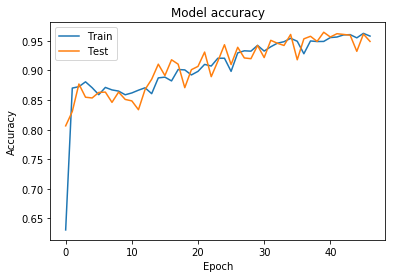

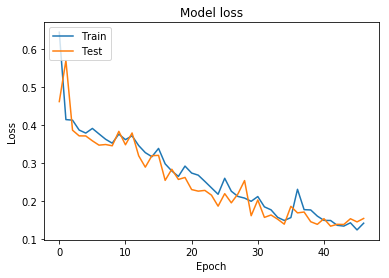

In [18]:
early_stoping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=128, nb_epoch=100, validation_split=0.2, verbose=1, callbacks=[early_stoping], class_weight=class_weights)

# Plot training & validation accuracy values
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Test

In [19]:
test_metrics = model.evaluate(x=X_test, y=y_test)
print("Loss: %f" % test_metrics[0])
print("Accuracy: %f" % test_metrics[1])

3970/3970 [==============================] - 50s 13ms/step
Loss: 0.140130
Accuracy: 0.955164


#### Confusion Matrix

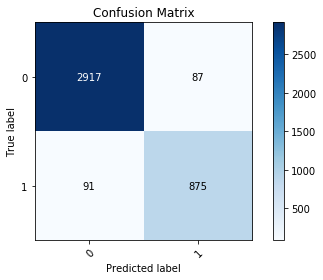

In [20]:
y_pred = [1 if i > 0.5 else 0 for i in model.predict(X_test)]

cm = confusion_matrix(y_test, y_pred)
classes = [0, 1]

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title="Confusion Matrix",
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()

In [21]:
print("Precision: %f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
print("Recal: %f" % (cm[1][1] / (cm[1][1] + cm[1][0])))

Precision: 0.909563
Recal: 0.905797


### Saving the model

In [22]:
model_name_version = "spam_detector-%i" % time.time()

In [23]:
model.save_weights("%s.h5" % model_name_version)
# model.load_weights("%s.h5" % model_name_version, by_name=True)

In [24]:
output_node_names = ['output_node0']
tf.identity(model.output[0], name=output_node_names[0])

signature = predict_signature_def(
    inputs={"inputs": model.input}, 
    outputs={"outputs": model.output}
)
valid_prediction_signature = tf.saved_model.signature_def_utils.is_valid_signature(signature)
if(valid_prediction_signature == False):
    raise ValueError("Error: Prediction signature not valid!")

model_parameters = {
    "input_name": model.input.name,
    "input_dtype": model.input.dtype.as_numpy_dtype().__class__.__name__,
    "input_shape": model.input.shape.as_list(),
    "graph_output_name": output_node_names[0],
    "output_name": model.output.name,
    "output_dtype": model.output.dtype.as_numpy_dtype().__class__.__name__,
    "output_shape": model.output.shape.as_list(),   
    "method_name": str(signature.method_name),
    "max_sequence_length": max_sequence_length,
    "keyword_index": {},
}
print(json.dumps(model_parameters, indent=4, sort_keys=True))

model_parameters["keyword_index"] = tokenizer.index_word

with open("%s.json" % model_name_version, 'w') as f:
    f.write(json.dumps(model_parameters, indent=4, sort_keys=True))

with open("%s.json" % model_name_version, 'w') as f:
    f.write(json.dumps(model_parameters, indent=4, sort_keys=True))
    
builder = saved_model_builder.SavedModelBuilder("./%s/" % model_name_version)

with K.get_session() as sess:
    
    # save model
    builder.add_meta_graph_and_variables(
        sess=sess, 
        tags=[tag_constants.SERVING], 
        signature_def_map={
            signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature
        }
    )
    builder.save()


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
{
    "graph_output_name": "output_node0",
    "input_dtype": "float32",
    "input_name": "lstm_1_input:0",
    "input_shape": [
        null,
        300,
        1
    ],
    "keyword_index": {},
    "max_sequence_length": 300,
    "method_name": "tensorflow/serving/predict",
    "output_dtype": "float32",
    "output_name": "dense_1/Sigmoid:0",
    "output_shape": [
        null,
        1
    ]
}
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./spam_detector-1554147249/saved_model.pb
